In [31]:
import numpy as np
import pandas as pd
import scipy as sp
from collections import OrderedDict
from tqdm import tqdm
from typing import Dict

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding, Flatten, Input, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_pickle('../datasets/clean_df.csv', compression='zip')

In [3]:
# Convert user id and song id to numerical ids
df['user_id'] = df['user'].astype('category').cat.codes
df['song_id'] = df['song'].astype('category').cat.codes

df_orig = df.copy()

# Create lookup frame so we can get the 'Song - Artist' later
item_lookup = df[['song_id','Song - Artist']].drop_duplicates()
item_lookup['song_id'] = item_lookup['song_id'].astype(str)

# Drop 'user' and 'song' and 'Song - Artist'
df = df.drop(['user','song','Song - Artist'], axis=1)

# Create lists of all users, songs, and counts
users = list(np.sort(df['user_id'].unique()))
songs = list(np.sort(df['song_id'].unique()))
play_counts = list(np.sort(df['count']))

# Get the rows and columns for our matrix
user_ = df['user_id'].astype(float)
item_ = df['song_id'].astype(float)

### Train/test split

The main idea here is to see if our model recommends any of the songs a user has listened to many times. We know these song items are most likely positive (well-liked by the user), so we can measure goodness of the model based on how many of these positive items it recommends.

#### Test split

In [4]:
# Get the users that have listened to any song more than 4 times
min_listens = 4
tmp_test = df[df['count'] > min_listens]
tmp_test = (
        tmp_test.groupby('user_id')['song_id'].count()
    ).reset_index().rename({'song_id':'records'}, axis=1)
tmp_test.shape

(87253, 2)

In [5]:
min_records = 4
conditions = (df['user_id'].isin(tmp_test[tmp_test['records'] > min_records].user_id) & (df['count'] > min_listens))
df_test = df[conditions].groupby('user_id').head(2).reset_index()
del df_test['index']
df_test.shape

(428, 3)

In [6]:
ground_truth_test = df_test.groupby('user_id')['song_id'].agg(list).reset_index()
ground_truth_test.shape

(214, 2)

In [45]:
ground_truth_test.head()

,user_id,song_id
0,3128,"[2918, 964]"
1,3694,"[3548, 964]"
2,5314,"[1424, 1918]"
3,5496,"[2210, 2924]"
4,7070,"[2994, 1424]"


In [46]:
df_test.head()

,count,user_id,song_id
0,13,82030,3269
1,7,135080,3269
2,7,235886,3269
3,17,257077,3269
4,5,162425,3269


#### Train split

In [7]:
df_train = pd.concat([df, df_test]).drop_duplicates(keep=False)
df_train.shape

(772233, 3)

In [8]:
ground_truth_train = df_train[df_train['count'] > 4].groupby('user_id')['song_id'].agg(list).reset_index()
ground_truth_train.shape

(87253, 2)

#### Building triplets

Need to find users that:
- Have 3 positive items (listen count > 1)
    - 2 positive items extracted for testing
    - 1 positive item used for triplet
- Have 1 negative item (listen count == 1)

In [9]:
num_records_for_user = pd.DataFrame(
    df_train.groupby(['user_id'])['song_id'].count().reset_index()
).rename({'song_id' : 'records'}, axis=1)

In [10]:
candidate_users = num_records_for_user[num_records_for_user['records'] > 2]['user_id'].tolist()
len(candidate_users)

80513

In [11]:
%%time

df_triplets = pd.DataFrame(columns=['user_id','pos_song','neg_song'])

data = []
unqualified_users = []
threshold = 1

for i, user in enumerate(candidate_users):
    if ( i % 10_000 == 0 ):
        print(f'{i} users processed. ' +
              f'Found {i - len(unqualified_users)} qualified users. ' +
              f'{len(candidate_users) - i} users remaining.')
    pos_songs = df_train[(df_train['user_id'] == user) & 
                              (df_train['count'] > threshold)]['song_id'].values
    neg_songs = df_train[(df_train['user_id'] == user) &
                              (df_train['count'] == threshold)]['song_id'].values
    
    if ( len(pos_songs) == 0 or len(neg_songs) == 0 ):
        unqualified_users.append(user)
        continue
        
    for pos in pos_songs:
        for neg in neg_songs:
            data.append({
                'user_id' : user,
                'pos_song' : pos,
                'neg_song' : neg
            })
            
print('Building DataFrame...')
df_triplets = df_triplets.append(data, ignore_index=True)
df_triplets['user_id'] = df_triplets['user_id'].astype(float)
df_triplets['pos_song'] = df_triplets['pos_song'].astype(float)
df_triplets['neg_song'] = df_triplets['neg_song'].astype(float)

0 users processed. Found 0 qualified users. 80513 users remaining.
10000 users processed. Found 6823 qualified users. 70513 users remaining.
20000 users processed. Found 13617 qualified users. 60513 users remaining.
30000 users processed. Found 20351 qualified users. 50513 users remaining.
40000 users processed. Found 27137 qualified users. 40513 users remaining.
50000 users processed. Found 33920 qualified users. 30513 users remaining.
60000 users processed. Found 40736 qualified users. 20513 users remaining.
70000 users processed. Found 47548 qualified users. 10513 users remaining.
80000 users processed. Found 54346 qualified users. 513 users remaining.
Building DataFrame...
CPU times: user 9min 25s, sys: 26.6 s, total: 9min 51s
Wall time: 6min 16s


In [12]:
df_triplets.shape, df_train.shape

((286383, 3), (772233, 3))

In [13]:
df_triplets.head()

,user_id,pos_song,neg_song
0,1.0,2370.0,3548.0
1,1.0,2370.0,2818.0
2,4.0,366.0,1894.0
3,4.0,2580.0,1894.0
4,6.0,639.0,3548.0


### BPR NN

In [14]:
nusers = df['user_id'].nunique()
nsongs = df['song_id'].nunique()
unique_songs = list(df['song_id'].unique())

#### Build model

In [15]:
def bpr_predict(model: Model, user_id: int, song_ids: list, user_layer='user_embedding', item_layer='item_embedding'):
    user_vector = model.get_layer(user_layer).get_weights()[0][user_id]
    item_matrix = model.get_layer(item_layer).get_weights()[0][song_ids]
    
    scores = np.dot(user_vector, item_matrix.T)
    
    return scores

In [16]:
@tf.function
def identity_loss(_, y_pred):
    return tf.math.reduce_mean(y_pred)

In [17]:
@tf.function
def bpr_triplet_loss(X: dict):
    """
    Calculate triplet loss - as higher the difference between positive interactions
    and negative interactions as better

    :param X: X contains the user input, positive item input, negative item input
    :return:
    """
    positive_item_latent, negative_item_latent, user_latent = X

    positive_interactions = tf.math.reduce_sum(tf.math.multiply(user_latent, positive_item_latent), axis=-1, keepdims=True)
    negative_interactions = tf.math.reduce_sum(tf.math.multiply(user_latent, negative_item_latent), axis=-1, keepdims=True)

    return tf.math.subtract(tf.constant(1.0), tf.sigmoid(tf.math.subtract(positive_interactions, negative_interactions)))

In [18]:
def out_shape(shapes):
    return shapes[0]
    

def build_model(num_users: int, num_items: int, latent_dim: int) -> Model:
    """
    Build a model for Bayesian personalized ranking

    :param num_users: a number of the unique users
    :param num_items: a number of the unique movies
    :param latent_dim: vector length for the latent representation
    :return: Model
    """
    user_input = Input((1,), name='user_input')

    positive_item_input = Input((1,), name='positive_item_input')
    negative_item_input = Input((1,), name='negative_item_input')
    # One embedding layer is shared between positive and negative items
    item_embedding_layer = Embedding(num_items, latent_dim, name='item_embedding', input_length=1)

    positive_item_embedding = Flatten()(item_embedding_layer(positive_item_input))
    negative_item_embedding = Flatten()(item_embedding_layer(negative_item_input))

    user_embedding = Embedding(num_users, latent_dim, name='user_embedding', input_length=1)(user_input)
    user_embedding = Flatten()(user_embedding)

    triplet_loss = Lambda(bpr_triplet_loss, output_shape=out_shape)([positive_item_embedding,
                                                             negative_item_embedding,
                                                             user_embedding])

    model = Model(inputs=[positive_item_input, negative_item_input, user_input], outputs=triplet_loss)

    return model

In [19]:
#---------------
#  HYPERPARAMS
#---------------
latent_dim = 350
batch_size = 256
num_epochs = 3
lr = 0.01

In [20]:
model = build_model(nusers, nsongs, latent_dim)
model.compile(loss=identity_loss, optimizer=Adam(learning_rate=lr))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
positive_item_input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
negative_item_input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 350)       1286250     positive_item_input[0][0]        
                                                                 negative_item_input[0][0]    

In [21]:
%%time

X = {
    'user_input': tf.convert_to_tensor(df_triplets['user_id']),
    'positive_item_input': tf.convert_to_tensor(df_triplets['pos_song']),
    'negative_item_input': tf.convert_to_tensor(df_triplets['neg_song'])
}

hist = model.fit(X, 
          tf.ones(df_triplets.shape[0]), 
          batch_size=batch_size,
          verbose=1,
          epochs=num_epochs)

Epoch 1/3
1119/1119 [==============================] - 2157s 2s/step - loss: 0.1392
Epoch 2/3
1119/1119 [==============================] - 31840s 28s/step - loss: 2.3320e-04
Epoch 3/3
1119/1119 [==============================] - 2109s 2s/step - loss: 6.0894e-05
CPU times: user 2h 46min 37s, sys: 1h 42min 39s, total: 4h 29min 16s
Wall time: 10h 1min 46s


In [23]:
model.save('../models/bpr_LOCAL_e3')

INFO:tensorflow:Assets written to: ../models/bpr_LOCAL_e3/assets


In [40]:
hist.history.keys()

dict_keys(['loss'])

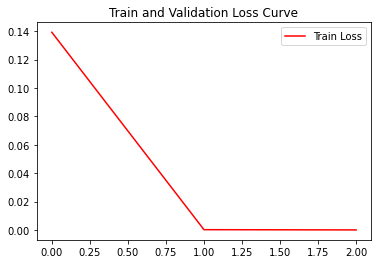

In [24]:
train_loss = hist.history['loss']
# val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
# plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [25]:
def full_auc(model: Model, ground_truth: Dict[int, list], items: list) -> float:
    """
    Measure AUC for model and ground truth for all items
    
    :param model: 
    :param ground_truth: dictionary of the users and the high ranked songs for the specific user
    :param items: a list of the all available songs
    :return: AUC
    """

    number_of_items = len(items)
    scores = []

    for i, (user_id, true_item_ids) in enumerate(ground_truth):
        if ( i > 0 and i % 1_000 == 0 ):
            print(f'{i} items processed. {len(ground_truth) - i} more items to process. Current AUC: {sum(scores) / len(scores)}')

        predictions = bpr_predict(model, user_id, items)
        grnd = np.zeros(number_of_items, dtype=np.int32)

        for p in true_item_ids:
            index = items.index(p)
            grnd[index] = 1

        if true_item_ids:
            scores.append(roc_auc_score(grnd, predictions))

    return sum(scores) / len(scores)

In [29]:
def mean_average_precision_k(model: Model, 
                           ground_truth: Dict[int, list], 
                           items: list, 
                           k=10) -> float:
    """
    Calculate mean average precision per user

    :param model: 
    :param ground_truth: dictionary of the users and the high ranked songs for the specific user
    :param items: a list of the all available songs
    :param k: top N recommendations per user
    :return: mean eavarage precission
    """
    
    scores = []
    
    for i, (user, actual) in enumerate(ground_truth):
        if ( i > 0 and i % 1_000 == 0 ):
            print(f'{i} items processed. {len(ground_truth) - i} more items to process. Current MAP@K {np.mean(scores)}')
            
        predictions = bpr_predict(model, user, items)
        predictions = dict(zip(items, predictions))
        predictions = sorted(predictions.items(), key=lambda kv: kv[1], reverse=True)[:k]
        predictions = list(OrderedDict(predictions).keys())

        score = 0.0
        num_hits = 0.0

        for i, p in enumerate(predictions):
            if p in actual:
                num_hits += 1.0
                score += num_hits / (i + 1.0)

        score = score / min(len(actual), k)
        scores.append(score)

    return np.mean(scores)

In [30]:
%%time
print('TRAIN:')
print(f'AUC train: {full_auc(model, ground_truth_train.values, unique_songs)}')

TRAIN:
1000 items processed. 86253 more items to process. Current AUC: 0.6276244361516711
2000 items processed. 85253 more items to process. Current AUC: 0.6232050987211324
3000 items processed. 84253 more items to process. Current AUC: 0.6188337168530617
4000 items processed. 83253 more items to process. Current AUC: 0.6167326126955692
5000 items processed. 82253 more items to process. Current AUC: 0.6158422564932029
6000 items processed. 81253 more items to process. Current AUC: 0.6154123491009121
7000 items processed. 80253 more items to process. Current AUC: 0.6158405896012885
8000 items processed. 79253 more items to process. Current AUC: 0.6150546440488502
9000 items processed. 78253 more items to process. Current AUC: 0.616756443599432
10000 items processed. 77253 more items to process. Current AUC: 0.6153022116491672
11000 items processed. 76253 more items to process. Current AUC: 0.6145197035777192
12000 items processed. 75253 more items to process. Current AUC: 0.613875115221

KeyboardInterrupt: 

In [32]:
%%time
print(f'Mean average precision train: {mean_average_precision_k(model, ground_truth_train.values, unique_songs)}')

1000 items processed. 86253 more items to process. Current MAP@K 0.18470773809523808
2000 items processed. 85253 more items to process. Current MAP@K 0.17971066468253968
3000 items processed. 84253 more items to process. Current MAP@K 0.1704055224867725
4000 items processed. 83253 more items to process. Current MAP@K 0.1693814236111111
5000 items processed. 82253 more items to process. Current MAP@K 0.1693366468253968
6000 items processed. 81253 more items to process. Current MAP@K 0.169764666005291
7000 items processed. 80253 more items to process. Current MAP@K 0.17182552437641724
8000 items processed. 79253 more items to process. Current MAP@K 0.17151558779761905
9000 items processed. 78253 more items to process. Current MAP@K 0.17419035493827162
10000 items processed. 77253 more items to process. Current MAP@K 0.17431016865079366
11000 items processed. 76253 more items to process. Current MAP@K 0.17348275613275613
12000 items processed. 75253 more items to process. Current MAP@K 0.

KeyboardInterrupt: 

In [34]:
%%time

print('TEST:')
print(f'AUC test: {full_auc(model, ground_truth_test.values, unique_songs)}')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print(f'Mean average precision test: {mean_average_precision_k(model, ground_truth_test.values, unique_songs)}')

TEST:
AUC test: 0.48179376658668577
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean average precision test: 0.01246754932502596
CPU times: user 3min 2s, sys: 2min 42s, total: 5min 44s
Wall time: 5min 25s
